In [1]:
import sys
sys.path.append("scripts/")
import numpy as np
from gridmap import*
from scipy.stats import expon, norm, uniform
from environment import*

In [2]:
class IdealRobot:
    def __init__(self, pose, agent=None, sensor=None, robot_color="black", path_color="red", r=0.4):
        self.pose = pose
        self.r = r
        self.robot_color = robot_color
        self.path_color = path_color
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor
    
    def draw(self, ax, elems):
        self.drawRobot(self.pose, ax, elems)
        self.poses.append(self.pose)
        self.drawTakenPath(self.poses, ax, elems)
        
        if self.sensor:
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):
            self.agent.draw(ax, elems, self.r)
    
    def state_transition(self, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*np.cos(t0), nu*np.sin(t0), omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(np.sin(t0 + omega*time) - np.sin(t0)), nu/omega*(-np.cos(t0 + omega*time) + np.cos(t0)), omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return
        obs, pos = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs, pos)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
    
    def calculateUncertainty(self, nu, omega, time_interval):
        return nu, omega
            
    def poseToIndex(self, pose):
        return (np.array(pose[0:2]) // self.world.grid_step).astype(np.int32)
    
    def indexToPose(self, index):
        return np.append(index * self.world.grid_step + self.world.grid_step / 2, 0.0)
    
    def isRobotInObstacle(self, pose):
        index = self.poseToIndex(pose)
        if self.world.isObstacle(index):
            return True
        for grid in neigbor_grids:
            neigbor_index = index + grid
            if self.world.isObstacle(neigbor_index):
                neigbor_pose = self.indexToPose(neigbor_index)
                dis_pose = np.abs(neigbor_pose - pose)[0:2] - self.world.grid_step / 2
                if np.all(grid == [1, 0]) or np.all(grid == [-1, 0]):
                    dis = dis_pose[0]
                elif np.all(grid == [0, 1]) or np.all(grid == [0, -1]):
                    dis = dis_pose[1]
                elif np.all(grid == [1, 1]) or np.all(grid == [-1, -1]) or np.all(grid == [1, -1]) or np.all(grid == [-1, 1]):
                    if dis_pose[0] < self.r and dis_pose[1] < self.r:
                        return True
                    else:
                        continue
                if dis < self.r:
                    return True
        return False
    
    def isInRange(self, angle, rangeMin, rangeMax):
        if(rangeMin < rangeMax):
            if(angle >= rangeMin and angle < rangeMax):
                return True
            else:
                return False
        else:
            if(angle >= rangeMin):
                return True
            elif(angle < rangeMax):
                return True
            else:
                return False
    
    def isRobotInGoal(self, pose):
        index = self.poseToIndex(pose)
        if self.world.isGoal(index):
            return True
        else:
            return False
        
    def drawRobot(self, pose, ax, elems=None):
        x, y, theta = pose
        xn = x + self.r * np.cos(theta)
        yn = y + self.r * np.sin(theta)
        elems += ax.plot([x,xn], [y,yn], color=self.robot_color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.robot_color)
        if elems is None:
            ax.add_pathch(c)
        else:
            elems.append(ax.add_patch(c))
    
    def drawTakenPath(self, poses, ax, elems=None, linewidth=0.5, label=None):
        if elems is None:
            ax.plot([e[0] for e in self.poses], [e[1] for e in poses], linewidth=linewidth, color=self.path_color, label=label)
        else:
            elems += ax.plot([e[0] for e in self.poses], [e[1] for e in poses], linewidth=linewidth, color=self.path_color, label=label)

In [3]:
class Robot(IdealRobot):
    def __init__(
        self, pose, agent=None, sensor=None, robot_color="black", path_color="red", r=0.4,
        noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.0,0.0),
        expected_stuck_time=1e100, expected_escape_time = 1e-100,
        expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)
    ):
        super().__init__(pose, agent, sensor, robot_color, path_color, r)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        
        self.stuck_pdf = expon(scale=expected_stuck_time)
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time)
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi))
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*omega*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval)

In [4]:
class Agent:
    def __init__(self, velocity=np.array([1.0, 10/180*np.pi]), nu_limit=[-1.0, 1.0], omega_limit=[-20/180*math.pi, 20/180*math.pi]):
        self.nu = velocity[0]
        self.omega = velocity[1]
        self.nu_min, self.nu_max = nu_limit
        self.omega_min, self.omega_max = omega_limit
        self.position = None
        
    def decision(self, observation=None, position=None):
        self.limitVelocity()
        self.position = position
        return self.nu, self.omega
    
    def limitVelocity(self):
        self.nu = self.nu_min if self.nu <= self.nu_min else self.nu
        self.nu = self.nu_max if self.nu >= self.nu_max else self.nu
        self.omega = self.omega_min if self.omega <= self.omega_min else self.omega
        self.omega = self.omega_max if self.omega >= self.omega_max else self.omega
    
    def draw(self, ax, elems, r):
        if self.position is not None:
            elems += ax.plot(
                [self.position[0]+r*math.cos(self.position[2]), self.position[0]+(r+self.nu)*math.cos(self.position[2])],
                [self.position[1]+r*math.sin(self.position[2]), self.position[1]+(r+self.nu)*math.sin(self.position[2])],
                color="cyan"
            )

In [5]:
class IdealCamera:
    def __init__(self, env_map, distance_range=(0.5, 6.0), direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):
        if polarpos is None:
            return False
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.obstacles:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))
            
        self.lastdata = observed
        pos = self.getPosition(cam_pose)
        return observed, pos
    
    def getPosition(self, obj_pos):
        return np.array([obj_pos[0], obj_pos[1], obj_pos[2]]).T
    
    def observation_function(self, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2 * np.pi
        while phi < -np.pi: phi += 2 * np.pi
        return np.array([np.hypot(*diff), phi]).T
    
    def draw(self, ax, elems, cam_pose):
        '''
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x, lx], [y, ly], color="pink")
        '''

<IPython.core.display.Javascript object>


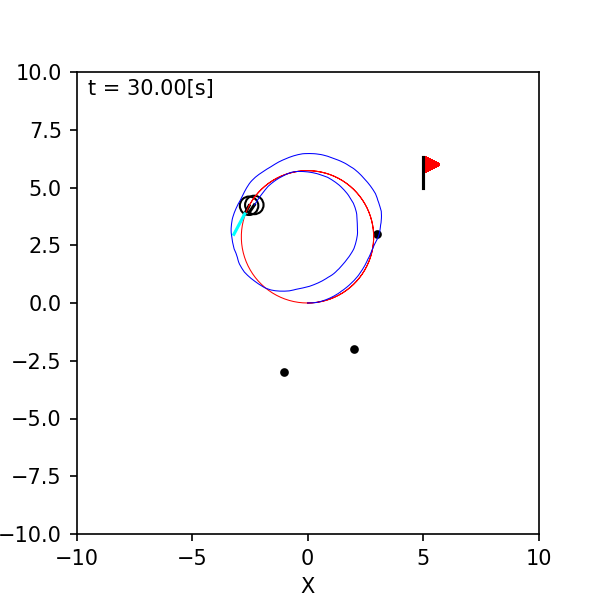

In [6]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    goal = [5, 5]
    map_size = [10, 10]
    
    world = World(time_span, time_interval, debug=False, map_size=map_size)

    m = Map(goal=goal, map_size=map_size)
    m.append_obstacle(Obstacle(2, -2))
    m.append_obstacle(Obstacle(-1, -3))
    m.append_obstacle(Obstacle(3, 3))
    world.append(m)
    
    circling1 = Agent(np.array([1.0, 20/180*np.pi]))
    circling2 = Agent(np.array([0.5, 20/180*np.pi]))
    robot1 = IdealRobot(np.array([0, 0, 0]), circling1, IdealCamera(m))
    robot2 = Robot(np.array([0, 0, 0]), circling1, IdealCamera(m), path_color="blue")
    world.append(robot1)
    world.append(robot2)
    
    world.draw()